In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [2]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        #self.timestamps = timestamps
    def old_interp (self):
        resolution = 10 #desired resolution in ms
        expt_len = 1000*30*60
        fps = 50 #of fictrac camera
        behaviors = ['dRotLabY', 'dRotLabZ']
        self.fictrac = {}
        for behavior in behaviors:
            if behavior == 'dRotLabY': short = 'Y'
            elif behavior == 'dRotLabZ': short = 'Z'
            self.fictrac[short] = bbb.smooth_and_interp_fictrac(self.fictrac_raw, fps, resolution, expt_len, behavior)
        xnew = np.arange(0,expt_len,resolution)
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior#/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [ ]:
#######################
### Load Superslice ###
#######################
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)

#####################
### Make Clusters ###
#####################
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)
cluster_model_labels = cluster_model_labels[z,:]

In [3]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res
z=20

In [4]:
# fly_names = ['fly_086', 'fly_087', 'fly_088','fly_089', 'fly_092', 'fly_093', 'fly_094', 'fly_095', 'fly_096',
#          'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_103', 'fly_104', 'fly_105', 'fly_106',
#          'fly_107', 'fly_109', 'fly_110', 'fly_111']

In [5]:
fly_names = ['fly_085', 'fly_086', 'fly_087', 'fly_088', 'fly_089', 'fly_090', 'fly_092', 'fly_093', 'fly_094', 'fly_095', 'fly_096',
         'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_103', 'fly_104', 'fly_105', 'fly_106', 'fly_107', 
         'fly_109', 'fly_110', 'fly_111']

In [6]:
###################
### Build Flies ###
###################

flies = {}
for i, fly in enumerate(fly_names):
    print(fly)
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    #flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.old_interp()
    #flies[fly].fictrac.interp_fictrac(z)
    #flies[fly].load_anatomy()

fly_085

~~ load_fictrac ~~
load_fictrac done. Duration: 4.36 sec
fly_086

~~ load_fictrac ~~
load_fictrac done. Duration: 3.46 sec
fly_087

~~ load_fictrac ~~
load_fictrac done. Duration: 3.48 sec
fly_088

~~ load_fictrac ~~
load_fictrac done. Duration: 3.22 sec
fly_089

~~ load_fictrac ~~
load_fictrac done. Duration: 3.27 sec
fly_090

~~ load_fictrac ~~
load_fictrac done. Duration: 3.27 sec
fly_092

~~ load_fictrac ~~
load_fictrac done. Duration: 3.28 sec
fly_093

~~ load_fictrac ~~
load_fictrac done. Duration: 3.23 sec
fly_094

~~ load_fictrac ~~
load_fictrac done. Duration: 3.25 sec
fly_095

~~ load_fictrac ~~
load_fictrac done. Duration: 3.33 sec
fly_096

~~ load_fictrac ~~
load_fictrac done. Duration: 3.25 sec
fly_097

~~ load_fictrac ~~
load_fictrac done. Duration: 3.22 sec
fly_098

~~ load_fictrac ~~
load_fictrac done. Duration: 3.27 sec
fly_099

~~ load_fictrac ~~
load_fictrac done. Duration: 3.34 sec
fly_100

~~ load_fictrac ~~
load_fictrac done. Duration: 3.26 sec
fly_101

~

In [7]:
sphere_radius = 4.5e-3 # in m
fps = 50

rejects = []
for i,fly in enumerate(fly_names):
    avgY = np.mean(np.abs(flies[fly].fictrac.fictrac['Y']))/(sphere_radius*1000*fps)
    avgZ = np.mean(np.abs(flies[fly].fictrac.fictrac['Z']))/(180/np.pi*fps)
    avg = avgY+avgZ
    if avg < .009:
        print('{} {}'.format(fly, avg))
        rejects.append(fly)
#     if avgY > .5:
#         #print('Y {} {}'.format(fly, avgY))
#         pass
#     if avgZ > 20:
#         print('Z {} {}'.format(fly, avgZ))

fly_088 0.001337464690617813
fly_090 0.0030695632868788787
fly_092 0.005756196157177711
fly_103 0.007251863130087065
fly_106 0.004818613539136524
fly_107 0.007357481145076327


In [ ]:
sphere_radius = 4.5e-3 # in m
#Y sphere_radius * fps * 1000
#Z 180 / np.pi * fps

In [12]:
manual_rejects = ['fly_096', 'fly_093', 'fly_109']
final_flies = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

In [10]:
plt.rcParams.update({'font.size': 12})

In [51]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.transforms import Bbox
import matplotlib.font_manager as fm


In [35]:
len(flies[fly].fictrac.fictrac['Y'])

180000

In [38]:
180000*(5/30)

30000.0

In [40]:
30000/5

6000.0

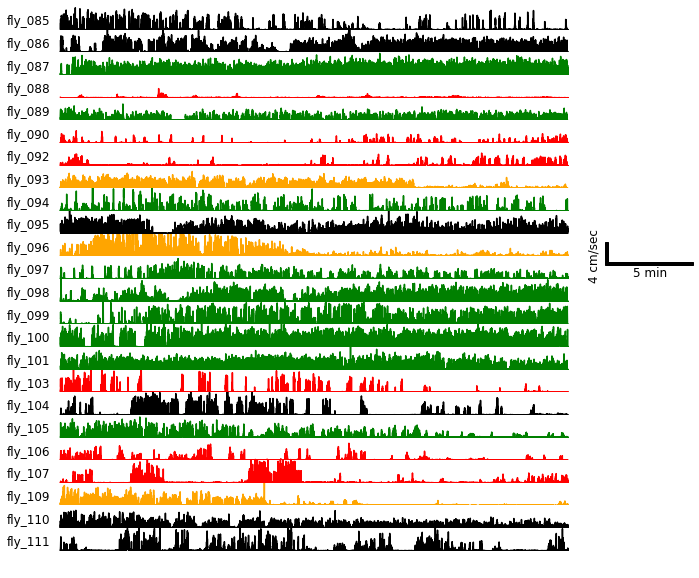

In [101]:
fig = plt.figure(figsize=(10,10))

for i,fly in enumerate(fly_names):
    if fly in rejects:
        color='r'
    elif fly in manual_rejects:
        color='orange'
    elif fly in final_flies:
        color='green'
    else:
        color='k'
    
    ax = plt.subplot(24,1,i+1)
    Y = np.abs(flies[fly].fictrac.fictrac['Y'])#/(sphere_radius*1000*fps)
    Z = (sphere_radius*1000*fps)*np.abs(flies[fly].fictrac.fictrac['Z'])/(180/np.pi*fps)
    to_plot = np.sqrt(Y**2 + Z**2)
    ax.plot(to_plot,color=color)
    plt.axis('off')
    plt.ylim(0,40)
    plt.text(s=fly,x=-.05,y=0.2,transform=ax.transAxes)
    
    if fly == 'fly_085':
        scalebar = AnchoredSizeBar(ax.transData,
                           30000, '5 min', 'lower right', 
                           pad=0,
                           color='black',
                           frameon=False,
                           size_vertical=4,
                           bbox_to_anchor=Bbox.from_bounds(.04, .5, 1, 1),
                           bbox_transform=ax.figure.transFigure)
        ax.add_artist(scalebar)
        
        scalebar = AnchoredSizeBar(ax.transData,
                   1000, '', 'lower right', 
                   pad=0,
                   color='black',
                   frameon=False,
                   size_vertical=40,
                   bbox_to_anchor=Bbox.from_bounds(-.078, .5, 1, 1),
                   bbox_transform=ax.figure.transFigure)
        ax.add_artist(scalebar)
        
        ax.text(s='4 cm/sec',x=187000,y=-370,rotation=90)
    
#     ax = plt.subplot(24,2,i*2+2)
#     to_plot = flies[fly].fictrac.fictrac['Z']
#     plt.plot(to_plot,color=color)
#     plt.axis('off')
#     plt.ylim(-600,600)

plt.subplots_adjust(wspace = 0, hspace = 0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [83]:
(180/np.pi*fps), (sphere_radius*1000*fps)

(2864.7889756541163, 225.0)

In [103]:
def strike(text):
    result = ''
    for c in text:
        result = result + c + '\u0336'
    return result

In [104]:
rejects = ['fly_088', 'fly_090', 'fly_092', 'fly_093', 'fly_096', 'fly_103', 'fly_104', 'fly_106', 'fly_107', 'fly_109']

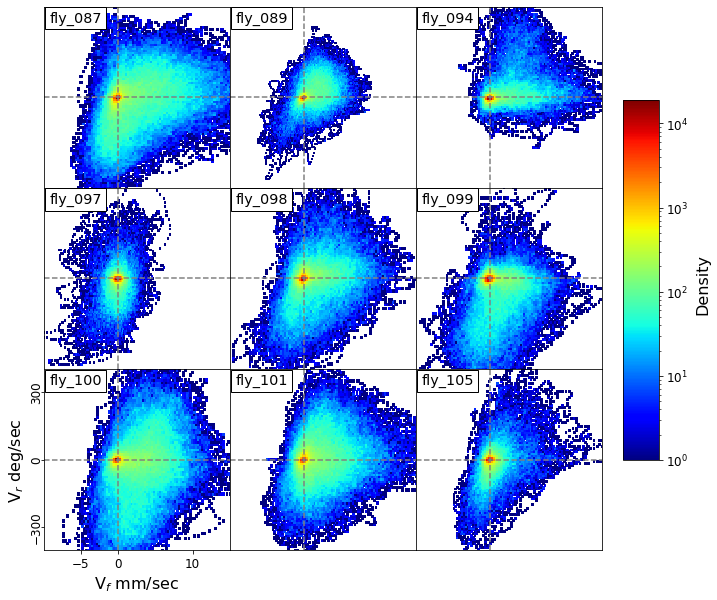

In [118]:
fig = plt.figure(figsize=(10,10))
norm = mpl.colors.LogNorm()
plt.rcParams.update({'font.size': 12})

for i,fly in enumerate(final_flies):
    ax = plt.subplot(3,3,i+1)
    H = ax.hist2d(flies[fly].fictrac.fictrac['Y'],
                   flies[fly].fictrac.fictrac['Z'],
                   bins=100,cmap='jet',norm=norm);
    if fly != 'fly_100':
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.ylabel('V$_r$ deg/sec',fontsize=16)
    plt.xlabel('V$_f$ mm/sec',fontsize=16)
    plt.ylim(-400,400)
    plt.xlim(-10,15)
    plt.yticks([-300,0,300])
    plt.xticks([-5,0,10])
    plt.axvline(0,color='grey',linestyle='--')
    plt.axhline(0,color='grey',linestyle='--')
    plt.yticks(rotation='vertical', va='center', ha='center')
    if fly in rejects:
        plt.title(strike(fly),x=.03,y=.8,ha='left',color='r')
    else:
        plt.title(fly,x=.03,y=.88,ha='left',bbox=dict(facecolor='white'))
    
    plt.subplots_adjust(wspace = 0, hspace = 0)

cax = fig.add_axes([.93, .25, 0.05, 0.5])
fig.colorbar(H[3], ax=ax, cax=cax)
fig.text(s='Density', fontsize=16,x=1.03,y=.52,rotation=90)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [143]:
len(fly_names)

22